# Visualizing COVID-19 Growth 

I wanted to see and compare state-level growth curves for the US, so I wrote this notebook to pull data from [http://covidtracking.com](http://covidtracking.com/) and plot the daily and total increase in COVID-19 cases in all US states

In [2]:
from os import lstat
from subprocess import call
import requests
import pandas as pd
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.dates import num2date
from matplotlib.ticker import FuncFormatter

The data retrieval is a bit indulgent. You can just use the `data_url` with the `requests` command (next cell) to get the CSV. I prefer to fetch the CSV twice a day; the next cell just checks and then downloads the latest CSV if its older than 12 hours. The source seems to update the data once every few hours, daily.

In [14]:
data_url = 'https://covidtracking.com/api/states/daily.csv'
data_path = 'daily.csv' #assuming the file is in the same directory as the notebook
name_path = 'state_names.csv'
now = dt.datetime.now()
csv_time = dt.datetime.fromtimestamp(lstat(data_path).st_mtime)
# lstat gives me the modification time.

if now - csv_time > dt.timedelta(0.25):
    call(['rm', 'daily.csv'])
    call(['wget', data_url])
    print('Downloaded an updated dataset')

Downloaded an updated dataset


In [ ]:
csv = requests.get(data_url) # to directly import from api

This is just a dictionary with a method to call up full state names from abbreviations. Don't really need it, but saves time for typing the full state name

In [5]:
class StateNames():
    def __init__(self, name_path):
        self.name = {}
        for line in open(name_path):
            n, m = line.strip('\n').split(',')
            self.name[m] = n
    def fname(self, abr):
        return self.name[abr]

sn = StateNames(name_path)

In [15]:
def str_to_date(x):
    return dt.datetime.strptime(str(x),'%Y%m%d')

df = pd.read_csv(data_path, converters={'date' : str_to_date})

In [ ]:
df.head()

In [7]:
def select_state(abr):
    # abbreivation
    # postiveIncrease >= 10 to not worry about log(0)
    state = df[(df['state'] == abr) & (df['positiveIncrease'] >= 10)].sort_values('date')
    return state

In [8]:
def ticks_log(x, pos):
    # two args are the value and tick position
    if x < 3:
        return '{:1.0f}'.format(10**x)
    return '{:1.0f}K'.format(10**x/1000)

def ticks_line(x, pos):
    # two args are the value and tick position
    if x < 1000:
        return '{:1.0f}'.format(x)
    return '{:1.0f}K'.format(x/1000)

def xticks_date(x, pos):
    # two args are the value and tick position
    # i had to use num2date as the dateobject is converted to numpy array at some point
    return '{}'.format(dt.datetime.strftime(num2date(x),'%b %d'))

In [16]:
def plot_totdaily(state_abr, log=True, sn=sn):
    
    state = select_state(state_abr)
    name = sn.fname(state_abr)
    
    x = state['date']
    y_daily = state['positiveIncrease']
    if log is True:
        y_tot = np.log10(state['positive'])
    else:
        y_tot = state['positive']
    
    fig, ax1 = plt.subplots(figsize=(8,6))

    color = 'tab:red'
    ax1.set_ylabel('New Positive Cases', color=color)  # we already handled the x-label with ax1
    ax1.bar(x, y_daily, color=color, alpha= 0.7)
    ax1.tick_params(axis='y', labelcolor=color)
  
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    
    color = 'tab:blue'
    ax2.set_ylabel('Cumulative Cases', color=color)
    ax2.plot(x, y_tot, color=color, lw=3)
    ax2.tick_params(axis='y', labelcolor=color)
    
    if log is True:
        formatter = FuncFormatter(ticks_log)
    else:
        formatter = FuncFormatter(ticks_line) 
    ax2.yaxis.set_major_formatter(formatter)

    # if you modify ax2, the ax1 defaults seem to overwrite them
    xformatter = FuncFormatter(xticks_date)
    ax1.xaxis.set_major_formatter(xformatter)
    ax1.tick_params(axis='x', rotation=60) 
    

    ax2.set_title(f'Coronavirus Cases in {name}')
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    #plt.show()


In [17]:
def plot_logcomp(st1_abr, st2_abr, log=True, sn=sn):
    
    st1 = select_state(st1_abr)
    st2 = select_state(st2_abr)
    
    sn1 = sn.fname(st1_abr)
    sn2 = sn.fname(st2_abr)
    
    x1 = st1['date']
    x2 = st2['date']
    if log is False:
        y1 = st1['positive']
        y2 = st2['positive']
    else:
        y1 = np.log10(st1['positive'])
        y2 = np.log10(st2['positive'])
    
    fig, ax1 = plt.subplots(figsize=(8,6))
    
    ax1.plot(x1, y1, color='tab:red', label=f'{sn1}', lw=2)
    ax1.plot(x2, y2, color='tab:blue', label=f'{sn2}', lw=2)
    
    linecol = 'gainsboro'
    labelcol = 'dimgray'
    
    ax1.set_title(f'Coronavirus Cases Comparison', color=labelcol, fontsize=14)
    ax1.set_ylabel('Cumalative Cases', color=labelcol, fontsize=14)
    
    ax1.tick_params(axis='y', color=linecol, labelcolor=labelcol, labelsize=12)    
    
    xformatter = FuncFormatter(xticks_date)
    ax1.xaxis.set_major_formatter(xformatter)
    ax1.tick_params(axis='x', rotation=60, color=linecol, labelcolor=labelcol, labelsize=12) 
    ax1.set_ylim(bottom=0)
    
    if log is True:
        formatter = FuncFormatter(ticks_log)
    else:
        formatter = FuncFormatter(ticks_line) 
    ax1.yaxis.set_major_formatter(formatter)
    
    ax1.grid(which='major', color=linecol)
    for sides in ax1.spines:
        ax1.spines[sides].set_color(None)
    ax1.spines['bottom'].set_color(linecol)
    
    leg = ax1.legend(frameon=False, loc='lower left')
    plt.setp(leg.get_texts(), color=labelcol)

    return

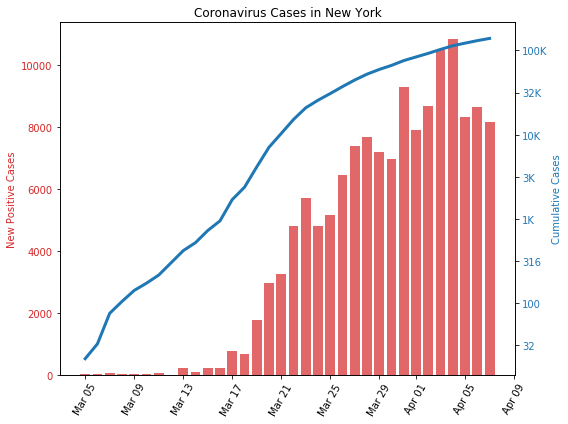

In [18]:
plot_totdaily('NY', log=True)

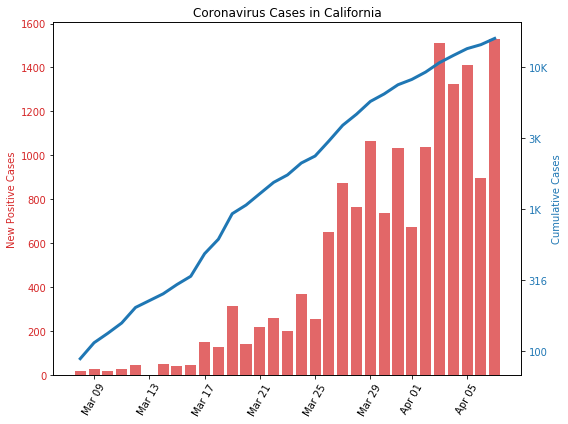

In [19]:
plot_totdaily('CA')

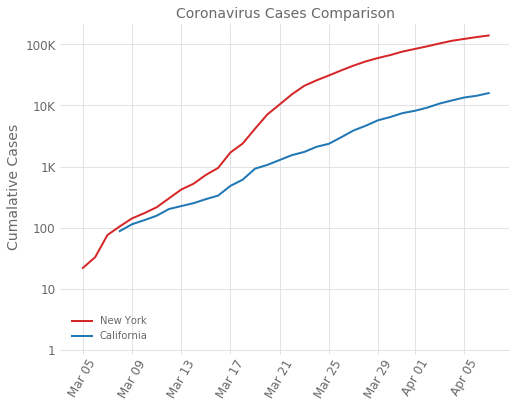

In [20]:
plot_logcomp('NY','CA', True)